# COS711 A2
> Dino Gironi (u21630276)

### Data Preprocessing

In [1]:
import pandas as pd
import numpy as np

pd.options.display.width = 200
pd.options.display.max_columns = 20

# Import Almond.csv
almondOrig: pd.DataFrame = pd.read_csv('Almond.csv')
almondOrig.columns = ['idx', 'len', 'wid', 'thk', 'area', 'perim', 'round', 'solid', 'compact', 'aspect', 'eccent', 'extent', 'convex', 'type']

#=============== PREPROCESSING ===============#

# Remove useless/redundant cols
# almond = almond.drop(['idx', 'round', 'aspect', 'eccent'], axis=1)
almond = almondOrig.drop(['idx'], axis=1)

# Convert target type to one-hot encoding & drop
typeOneHot = pd.get_dummies(almond['type'])
typeOneHot.columns = ['mamra', 'regular', 'sanora']
almond = almond.drop('type', axis=1)

# Convert numeric cols to numeric
almond = almond.apply(pd.to_numeric, errors='coerce')

print("-"*50 + " almond " + "-"*50)
print(almond)

# Isolate len, wid, thk cols & replace missing values with -1
dims: pd.DataFrame = almond[['len', 'wid', 'thk']]
dims = dims.fillna(-1)

# Create one-hot encoding for missing values
dimsOneHot = dims.copy()
dimsOneHot[dimsOneHot != -1] = 0
dimsOneHot[dimsOneHot == -1] = 1
dimsOneHot.columns = ['len1H', 'wid1H', 'thk1H']

print("-"*50 + " dims " + "-"*50)
print(dims.head(n=20))

print("-"*50 + " dimsOneHot " + "-"*50)
print(dimsOneHot.head(n=20))

# Sort within row + delete first col (empty after sort)
dimsSorted: pd.Series = dims.apply(np.sort, axis=1)
dims = pd.DataFrame(dimsSorted.values.tolist(), index=dimsSorted.index, columns=['null', 'wid', 'len'])
dims = dims[['wid', 'len']]

# Replace len, wid, thk cols in almond with sorted values
almond[['wid', 'len']] = dims
almond.drop('thk', axis=1, inplace=True)

# Insert one-hot encoding for missing values
almond.insert(2, 'thk1H', dimsOneHot['thk1H'])
almond.insert(2, 'wid1H', dimsOneHot['wid1H'])
almond.insert(2, 'len1H', dimsOneHot['len1H'])
almond[['len1H', 'wid1H', 'thk1H']] = dimsOneHot

# Recompute round, aspect, eccent with new len, wid
almond['round'] = 4 * almond['area'] / (np.pi * almond['len']**2)
almond['aspect'] = almond['len'] / almond['wid']
almond['eccent'] = np.sqrt(1 - (almond['wid'] / almond['len'])**2)

# Split to X, Y
# Y = almond['type']
X = almond.astype(float)
Y = typeOneHot.astype(int)

# Print fully preprocessed dataset
print("-"*50 + " Inputs (X) - fully preprocessed " + "-"*50)
print(X)
print("-"*50 + " Targets (Y) - fully preprocessed " + "-"*50)
print(Y)

-------------------------------------------------- almond --------------------------------------------------
             len         wid         thk     area       perim     round     solid   compact    aspect   eccent    extent   convex
0            NaN  227.940628  127.759132  22619.0  643.813269       NaN  0.973384  1.458265       NaN      NaN  0.681193  23237.5
1            NaN  234.188126  128.199509  23038.0  680.984841       NaN  0.957304  1.601844       NaN      NaN  0.656353  24065.5
2            NaN  229.418610  125.796547  22386.5  646.943212       NaN  0.967270  1.487772       NaN      NaN  0.683620  23144.0
3            NaN  232.763153  125.918808  22578.5  661.227483       NaN  0.965512  1.540979       NaN      NaN  0.685360  23385.0
4            NaN  230.150742  107.253448  19068.0  624.842706       NaN  0.951450  1.629395       NaN      NaN  0.714800  20041.0
...          ...         ...         ...      ...         ...       ...       ...       ...       ...      ... 

### Attribute distributions

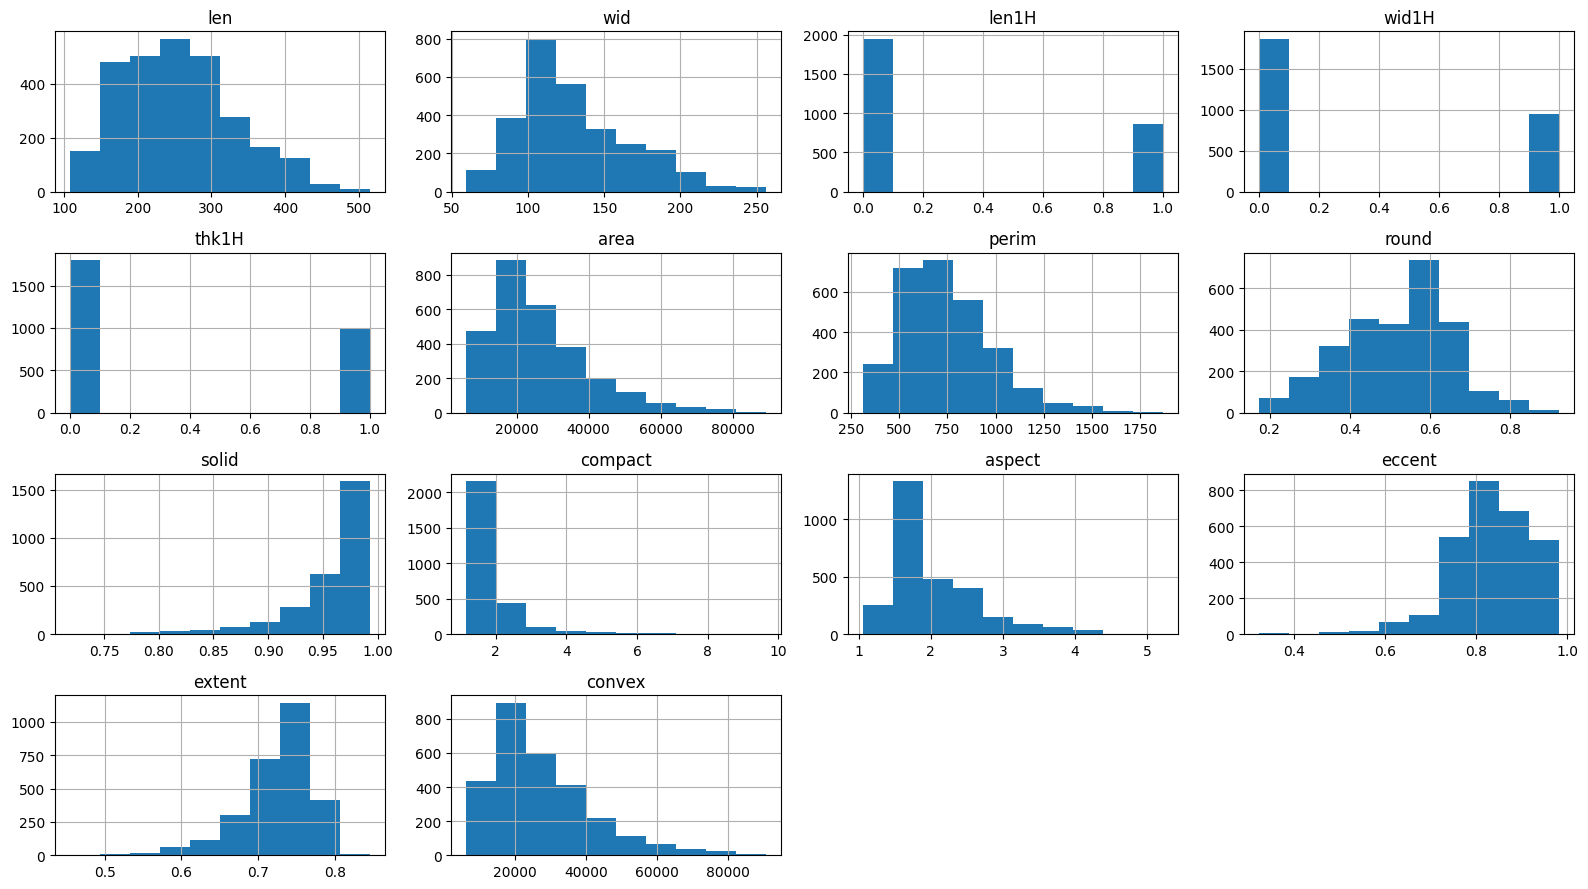

In [2]:
import matplotlib.pyplot as plt
X.hist(figsize=(16, 9))
plt.tight_layout()
plt.title("All attributes")
plt.show()

### Define neural net

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from typing import TypedDict, Callable, Tuple, List, cast

#----- Define NN -----#
class NeuralNet(nn.Module):
    def __init__(self, inDim, outDim, layerSize = 64, squeeze = 32, activation = nn.ReLU, dropout = 0):
        super(NeuralNet, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(inDim,     layerSize), activation(), nn.Dropout(dropout),
            nn.Linear(layerSize, layerSize), activation(), nn.Dropout(dropout),
            nn.Linear(layerSize, squeeze),   activation(), nn.Dropout(dropout),
            nn.Linear(squeeze,   layerSize), activation(), nn.Dropout(dropout),
            nn.Linear(layerSize, layerSize), activation(), nn.Dropout(dropout),
            nn.Linear(layerSize, outDim)
        )
    
    def forward(self, x):
        return self.stack(x)

#----- Wrapper types -----#
Net = TypedDict('Net', { 'model': NeuralNet, 'criterion': nn.Module, 'optimizers': List[optim.Optimizer] })
TrainResults = TypedDict('TrainResults', { 'losses': list, 'accuracies': list })
Runnable = Callable[[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor], Tuple[TrainResults, float]]

### Init & Splitting test/training

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from numpy import ndarray

#----- Get compute device -----#
dev = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
# dev = "cpu"
print(f"Using device: \033[0;94m{dev}\033[0m")


#----- Rescale & Encode features -----#
scaler = StandardScaler()
datX: ndarray = scaler.fit_transform(X.values)
datY: ndarray = Y.values

Using device: cuda


### Constructor functions

In [57]:
#----- Split test / training -----#
def runTrainTest(func: Runnable) -> Tuple[TrainResults, float]:
    global datX, datY
    trainX, testX, trainY, testY = train_test_split(datX, datY, test_size=0.2, random_state=69)

    # Convert to PyTorch tensors
    trainX = torch.tensor(trainX, dtype=torch.float32).to(dev)
    trainY = torch.tensor(trainY, dtype=torch.float32).to(dev)
    testX = torch.tensor(testX, dtype=torch.float32).to(dev)
    testY = torch.tensor(testY, dtype=torch.float32).to(dev)

    res = func(trainX, trainY, testX, testY)
    del trainX, trainY, testX, testY
    return res


#----- K-Fold -----#
def runKFold(func: Runnable, k: int = 5):
    global datX, datY
    kfold = KFold(n_splits=k, shuffle=True, random_state=69)

    results = []
    for a, b in kfold.split(datX, datY):
        trainX, trainY = torch.tensor(datX[a], dtype=torch.float32).to(dev), torch.tensor(datY[a], dtype=torch.float32).to(dev)
        testX, testY = torch.tensor(datX[b], dtype=torch.float32).to(dev), torch.tensor(datY[b], dtype=torch.float32).to(dev)
        res = func(trainX, trainY, testX, testY)
        results.append(res)
    return results


#----- NN creation function -----#
def createNN(inDim, outDim, loss = nn.MSELoss, opts = [optim.Rprop], act = nn.ReLU) -> Net:
    # Create model instance
    model = NeuralNet(inDim, outDim, activation = act).to(dev)

    # Define loss + optimizers
    criterion = loss()
    optimizers = [ opt(model.parameters()) for opt in opts ]

    return { 'model': model, 'criterion': criterion, 'optimizers': optimizers }


#----- Evaluation function -----#
def metrics(pred: np.ndarray, targ1H: np.ndarray) -> float:
    predLen = pred.shape[0]
    pred1H = np.zeros_like(pred).astype(int) # Convert pred to one-hot
    pred1H[np.arange(predLen), pred] = 1

    accuracy = np.sum(pred1H == targ1H) / (3 * predLen) # Acc for 3 val one-hot
    return accuracy


#----- Testing function -----#
def test(net: Net, x: torch.Tensor, y: torch.Tensor):
    model: NeuralNet = net["model"]

    model.eval()
    outputs = model(x)
    _, pred = torch.max(outputs, 1)
    pred1H = torch.zeros_like(outputs)
    pred1H[np.arange(outputs.shape[0]), pred] = 1

    acc = (pred1H == y).sum().item() / (3 * y.shape[0])
    return acc


#----- Training function -----#
def train(net: Net, x: torch.Tensor, y: torch.Tensor, epochs = 2000, printFreq = 100) -> TrainResults:
    model = net['model']; criterion = net['criterion']; optimizers = net['optimizers']
    model.train()

    losses, accs = [], []
    totCorrect, totSamples = 0, 0
    numOpt = len(optimizers)

    for e in range(epochs):
        #--- Forward pass ---#
        outputs: torch.Tensor = model(x)
        loss: torch.Tensor = criterion(outputs, y)

        _, predicted = torch.max(outputs, 1)
        pred1H = torch.zeros_like(outputs)
        pred1H[np.arange(outputs.shape[0]), predicted] = 1

        totCorrect += (pred1H == y).sum().item() / 3.0
        totSamples += y.shape[0]

        #--- Backward pass and optimization ---#
        # Clear grads for all optimizers
        for opt in optimizers:
            opt.zero_grad()

        loss.backward() # Compute new grads

        # Average grads
        for param in model.parameters():
            if param.grad is not None:
                param.grad /= numOpt

        # Step
        for opt in optimizers:
            opt.step()

        #--- Record metrics ---#
        [ l.append(v) for l, v in zip(
            [losses,        accs                    ],
            [loss.item(),   totCorrect / totSamples ])]

        if (e+1) % printFreq == 0:
            print(f'Epoch [ {e+1}/{epochs}\t], Loss:\t\033[0;93m{losses[-1]:.4f}\033[0m, Acc:\t\033[0;93m{accs[-1]:.4f}\033[0m')

    model.eval() # Set to evaluation mode

    return { 'losses': losses, 'accuracies': accs }

In [60]:
from typing import List, Tuple
def getRunner(epochs = 1000, loss = nn.MSELoss, opts = [optim.Rprop], act = nn.ReLU) -> Runnable:
    def runner(xTrain: torch.Tensor, yTrain: torch.Tensor, xTest: torch.Tensor, yTest: torch.Tensor) -> Tuple[TrainResults, float]:
        net = createNN(xTrain.shape[1], yTrain.shape[1], loss, opts, act)
        trainRes = train(net, xTrain, yTrain, epochs)
        testAcc = test(net, xTest, yTest)
        return trainRes, testAcc
    
    return runner

### Train once & Plot loss / accuracy

Epoch [ 100/2000	], Loss:	0.0554, Acc:	0.8429
Epoch [ 200/2000	], Loss:	0.0384, Acc:	0.8951
Epoch [ 300/2000	], Loss:	0.0332, Acc:	0.9167
Epoch [ 400/2000	], Loss:	0.0305, Acc:	0.9282
Epoch [ 500/2000	], Loss:	0.0287, Acc:	0.9354
Epoch [ 600/2000	], Loss:	0.0275, Acc:	0.9403
Epoch [ 700/2000	], Loss:	0.0266, Acc:	0.9441
Epoch [ 800/2000	], Loss:	0.0260, Acc:	0.9472
Epoch [ 900/2000	], Loss:	0.0255, Acc:	0.9498
Epoch [ 1000/2000	], Loss:	0.0251, Acc:	0.9518
Epoch [ 1100/2000	], Loss:	0.0248, Acc:	0.9536
Epoch [ 1200/2000	], Loss:	0.0245, Acc:	0.9551
Epoch [ 1300/2000	], Loss:	0.0242, Acc:	0.9563
Epoch [ 1400/2000	], Loss:	0.0240, Acc:	0.9575
Epoch [ 1500/2000	], Loss:	0.0238, Acc:	0.9585
Epoch [ 1600/2000	], Loss:	0.0235, Acc:	0.9594
Epoch [ 1700/2000	], Loss:	0.0233, Acc:	0.9602
Epoch [ 1800/2000	], Loss:	0.0231, Acc:	0.9609
Epoch [ 1900/2000	], Loss:	0.0230, Acc:	0.9616
Epoch [ 2000/2000	], Loss:	0.0229, Acc:	0.9623
Test accuracy with K fold: 0.8562


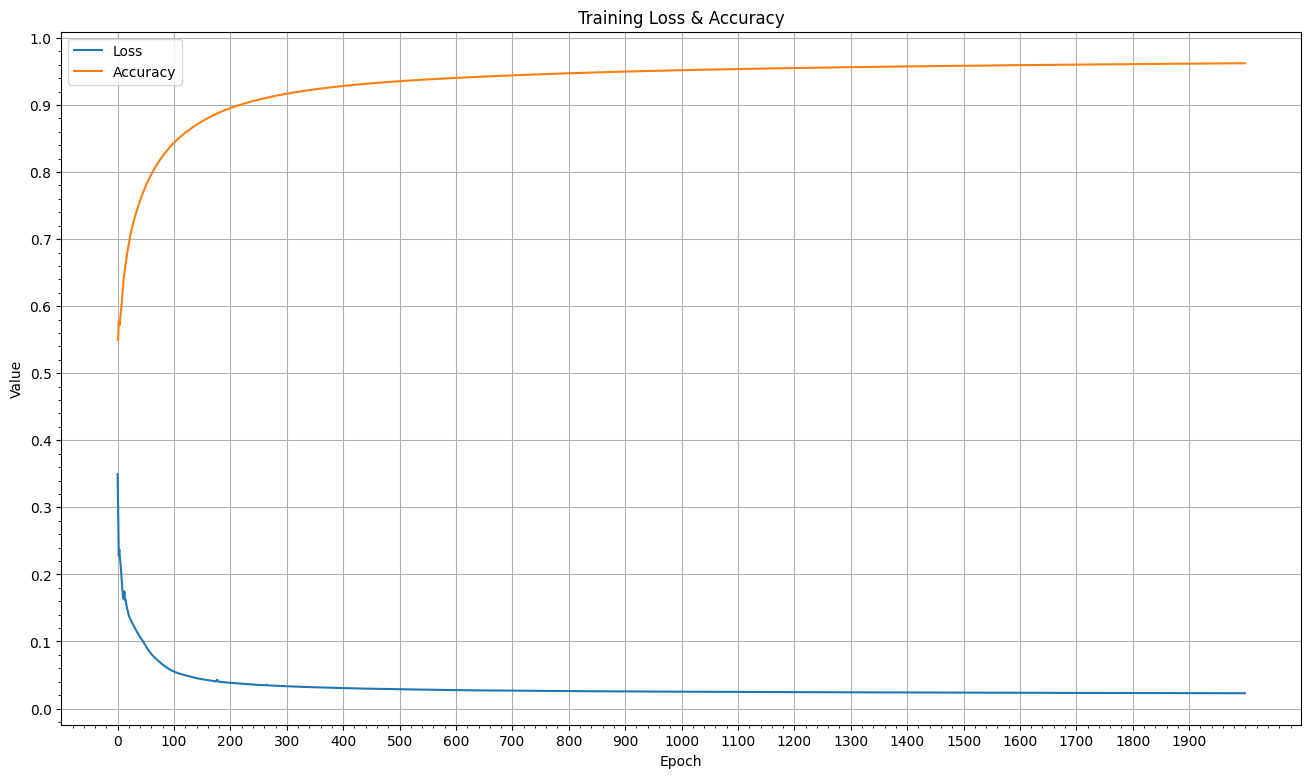

In [70]:
epcs = 2000

trainRes, testAcc = runTrainTest(getRunner(epcs))


# acc = test(net, testX, testY)
print(f'Test accuracy with K fold: \033[0;94m{testAcc:.4f}\033[0m')

# Plot accuracy & loss
plt.figure(figsize=(16, 9))
plt.plot(trainRes['losses'], label='Loss')
plt.plot(trainRes['accuracies'], label='Accuracy')
plt.title('Training Loss & Accuracy')
plt.minorticks_on()
plt.xticks(np.arange(0, epcs, epcs/20))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

### Grid Search w/ K-Fold Cross Validation

[1/24] Running grid search for loss: MSELoss, optimizer: Rprop
Epoch [ 100/100	], Loss:	0.0633, Acc:	0.8345
Epoch [ 100/100	], Loss:	0.0652, Acc:	0.8247
Epoch [ 100/100	], Loss:	0.0665, Acc:	0.8330
Epoch [ 100/100	], Loss:	0.0577, Acc:	0.8443
Epoch [ 100/100	], Loss:	0.0474, Acc:	0.8632
[2/24] Running grid search for loss: MSELoss, optimizer: Adam
Epoch [ 100/100	], Loss:	0.0560, Acc:	0.8576
Epoch [ 100/100	], Loss:	0.0735, Acc:	0.8289
Epoch [ 100/100	], Loss:	0.0686, Acc:	0.8256
Epoch [ 100/100	], Loss:	0.0636, Acc:	0.8252
Epoch [ 100/100	], Loss:	0.0585, Acc:	0.8448
[3/24] Running grid search for loss: MSELoss, optimizer: AdamW
Epoch [ 100/100	], Loss:	0.0642, Acc:	0.8382
Epoch [ 100/100	], Loss:	0.0599, Acc:	0.8380
Epoch [ 100/100	], Loss:	0.0625, Acc:	0.8402
Epoch [ 100/100	], Loss:	0.0683, Acc:	0.8347
Epoch [ 100/100	], Loss:	0.0615, Acc:	0.8456
[4/24] Running grid search for loss: MSELoss, optimizer: Adamax
Epoch [ 100/100	], Loss:	0.0672, Acc:	0.8328
Epoch [ 100/100	], Loss:	0.0

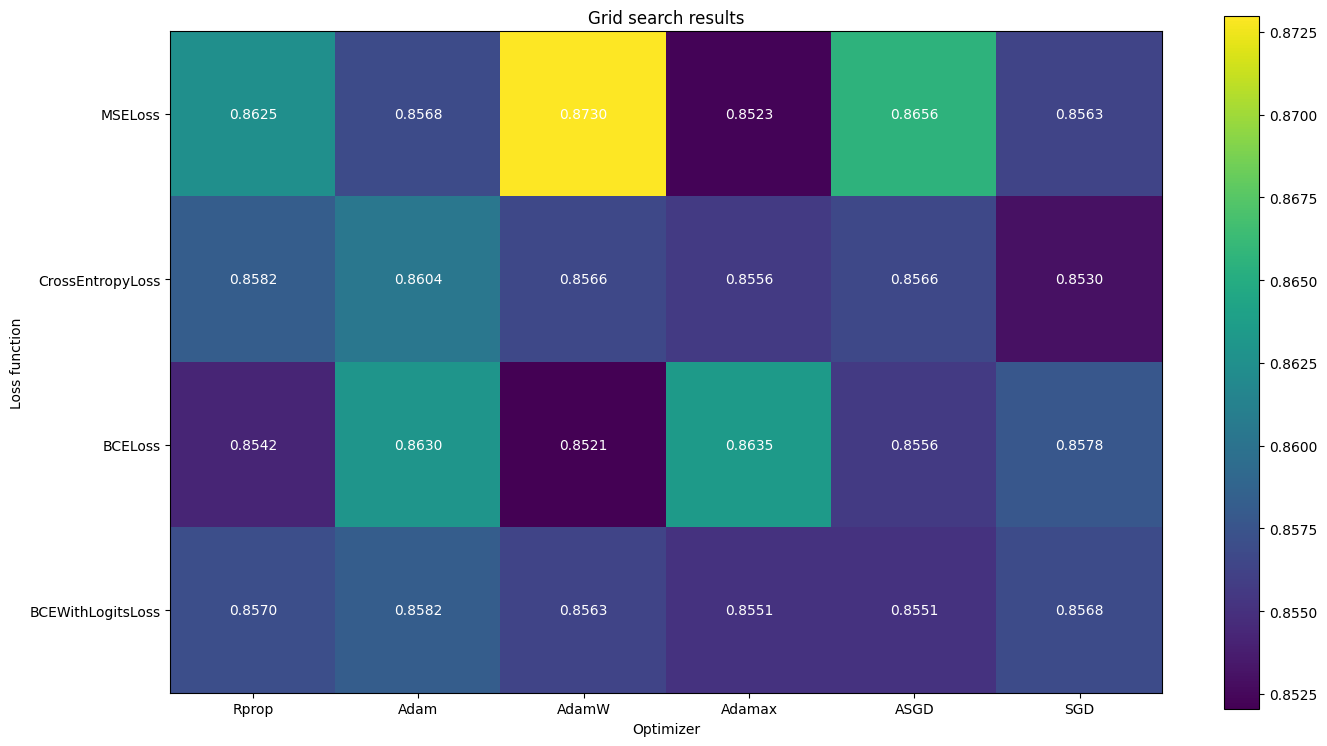

In [68]:
epcs = 100

#----- Run Grid search -----#
actFuncs = [nn.ReLU, nn.Sigmoid, nn.Tanh, nn.LeakyReLU]
lossFuncs = [nn.MSELoss, nn.CrossEntropyLoss, nn.BCELoss, nn.BCEWithLogitsLoss]
optimizers = [optim.Rprop, optim.Adam, optim.AdamW, optim.Adamax, optim.ASGD, optim.SGD]
# lossFuncs = [nn.MSELoss, nn.CrossEntropyLoss]
# optimizers = [optim.Rprop, optim.Adam]
learningRates = [0.1, 0.01, 0.001, 0.0001, 0.00001]

gridTrainLoss = []
gridTrainAcc = []
gridTestAcc = []
gridTrainLossStd = []
gridTrainAccStd = []
gridTestAccStd = []

i = 1
totIters = len(lossFuncs) * len(optimizers)
for loss in lossFuncs:
# for lr in learningRates:
    for opt in optimizers:
        print(f"[{i}/{totIters}] Running grid search for loss: {loss.__name__}, optimizer: {opt.__name__}")
        result: List[Tuple[TrainResults, float]] = runKFold(getRunner(epcs), k=5)
        print()

        gridTrainLoss.append(np.mean([trainRes["losses"][-1] for trainRes, _ in result]))
        gridTrainAcc.append(np.mean([trainRes["accuracies"][-1] for trainRes, _ in result]))
        gridTestAcc.append(np.mean([testAcc for _, testAcc in result]))

        gridTrainLossStd.append(np.std([trainRes["losses"][-1] for trainRes, _ in result]))
        gridTrainAccStd.append(np.std([trainRes["accuracies"][-1] for trainRes, _ in result]))
        gridTestAccStd.append(np.std([testAcc for _, testAcc in result]))

        i += 1

#----- Plot as heatmap -----#
plt.figure(figsize=(16, 9))
gridAcc = np.array(gridTestAcc)
gridAcc = gridAcc.reshape(len(lossFuncs), len(optimizers))

plt.imshow(gridAcc, cmap='viridis')
plt.colorbar()
plt.title('Grid search results')
plt.xticks(np.arange(len(optimizers)), [opt.__name__ for opt in optimizers])
plt.yticks(np.arange(len(lossFuncs)), [loss.__name__ for loss in lossFuncs])
plt.xlabel('Optimizer')
plt.ylabel('Loss function')

# Add text annotations
for y in range(gridAcc.shape[0]):
    for x in range(gridAcc.shape[1]):
        plt.text(x + 0, y + 0, '%.4f' % gridAcc[y, x], horizontalalignment='center', verticalalignment='center', color='white')

plt.show()

### Hybrid optimization

Epoch [ 100/2000	], Loss:	0.0550, Acc:	0.8546
Epoch [ 200/2000	], Loss:	0.0369, Acc:	0.8999
Epoch [ 300/2000	], Loss:	0.0278, Acc:	0.9202
Epoch [ 400/2000	], Loss:	0.0216, Acc:	0.9323
Epoch [ 500/2000	], Loss:	0.0176, Acc:	0.9413
Epoch [ 600/2000	], Loss:	0.0149, Acc:	0.9480
Epoch [ 700/2000	], Loss:	0.0127, Acc:	0.9533
Epoch [ 800/2000	], Loss:	0.0132, Acc:	0.9574
Epoch [ 900/2000	], Loss:	0.0106, Acc:	0.9605
Epoch [ 1000/2000	], Loss:	0.0112, Acc:	0.9629
Epoch [ 1100/2000	], Loss:	0.0103, Acc:	0.9653
Epoch [ 1200/2000	], Loss:	0.0077, Acc:	0.9675
Epoch [ 1300/2000	], Loss:	0.0085, Acc:	0.9688
Epoch [ 1400/2000	], Loss:	0.0064, Acc:	0.9706
Epoch [ 1500/2000	], Loss:	0.0058, Acc:	0.9721
Epoch [ 1600/2000	], Loss:	0.0053, Acc:	0.9734
Epoch [ 1700/2000	], Loss:	0.0052, Acc:	0.9747
Epoch [ 1800/2000	], Loss:	0.0044, Acc:	0.9758
Epoch [ 1900/2000	], Loss:	0.0043, Acc:	0.9765
Epoch [ 2000/2000	], Loss:	0.0042, Acc:	0.9775
Test accuracy with K fold: 0.8764


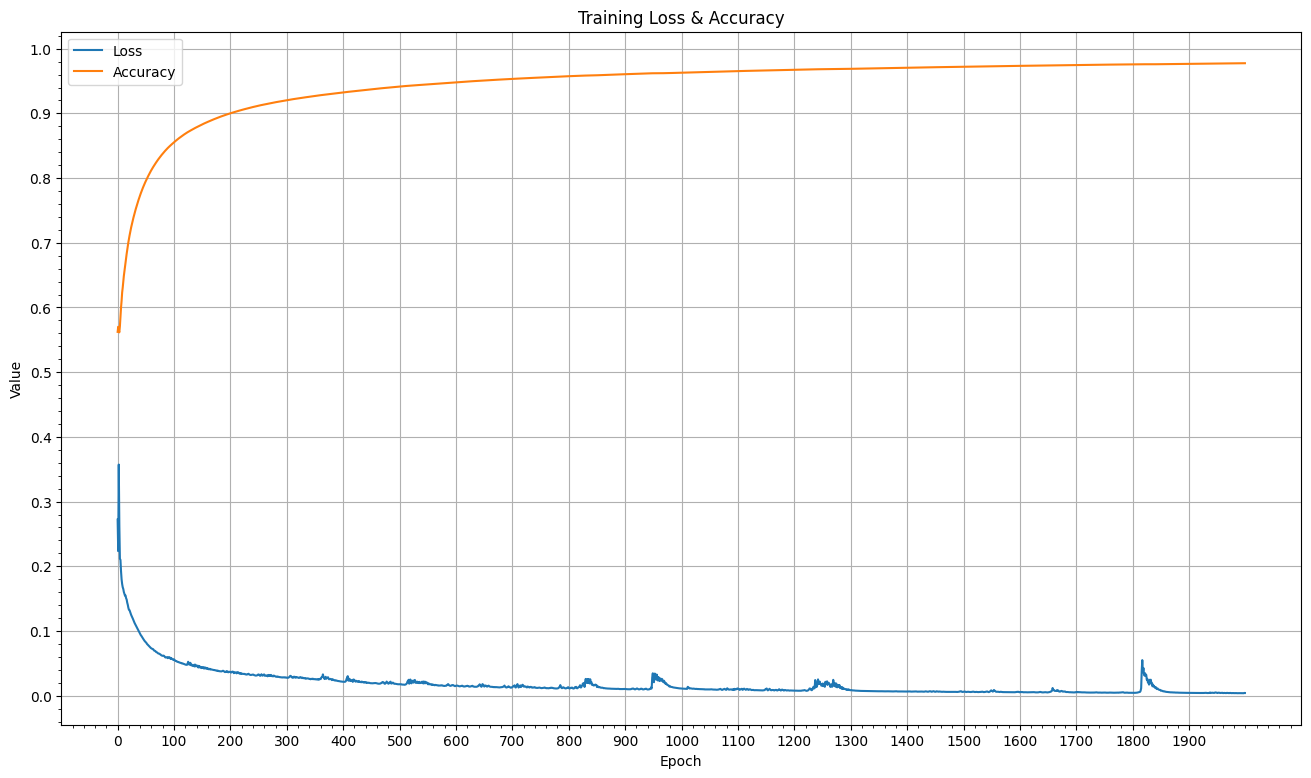

In [73]:
epcs = 2000

trainRes, testAcc = runTrainTest(getRunner(epcs, opts=[optim.Rprop, optim.Adam, optim.AdamW]))


# acc = test(net, testX, testY)
print(f'Test accuracy with K fold: \033[0;94m{testAcc:.4f}\033[0m')

# Plot accuracy & loss
plt.figure(figsize=(16, 9))
plt.plot(trainRes['losses'], label='Loss')
plt.plot(trainRes['accuracies'], label='Accuracy')
plt.title('Training Loss & Accuracy')
plt.minorticks_on()
plt.xticks(np.arange(0, epcs, epcs/20))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

### Hypothesis testing

In [ ]:
#----- Hypothesis testing -----#